#Libraries

In [244]:
!pip install Sastrawi

In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import string
import Sastrawi
import joblib
import math
import scipy.sparse as sp
from collections import Counter, defaultdict
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import lil_matrix


#word cloud
from wordcloud import WordCloud

#Input Data

##Text Dataset

In [246]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
file_path = '/content/drive/MyDrive/Tugas Akhire/Dataset/product_reviews_dirty.csv'

#load dataset
full_df = pd.read_csv(file_path)
full_df.sample(25)

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
24758,24909,Sir Bos merespon dgn cepat dan bang gojek meng...,5,elektronik,Tenda AC6 Dual Band AC1200 Mbps GIGABIT Wifi R...,237112849,752,2048686,https://www.tokopedia.com/multikomputer201/ten...
24994,25145,Mantap.............................,4,elektronik,Tenda N301 3 in 1 Wireless ROUTER+Access Point...,237114621,403,2048686,https://www.tokopedia.com/multikomputer201/ten...
2271,2287,"Barangnya mantaps\nSenang menjadi pelnggan, su...",4,fashion,X04 Rak sepatu 4 SUSUN payung holder lemari se...,411651606,"2,9rb",258554,https://www.tokopedia.com/nipponpowerbank/x04-...
4963,4992,Nyonya besar jadi gk cape tangannya make ini.....,5,handphone,Lazy Neck Lazyneck Holder Hp Leher Jepitan Dud...,369812705,99,2940563,https://www.tokopedia.com/obosacc/lazy-neck-la...
18740,18860,barang sudah terima maaf baru kasih ulasan,5,elektronik,USB HUB 3.0 7 port by DIGIGEAR HIGH SPEED 1.2 ...,170197447,"1,3rb",2048686,https://www.tokopedia.com/multikomputer201/usb...
6585,6629,bagus barang nya sesuai dengan gambar,5,handphone,GURITA HANDPHONE HOLDER NON PACKING - TEMPELAN HP,477566449,"3,4rb",2055662,https://www.tokopedia.com/konterr2f/gurita-han...
9932,10006,good.............................................,5,handphone,Hard Case Blackberry Style 9670 Merah Maroon,3526216,8,154793,https://www.tokopedia.com/aksesorieshp/hard-ca...
24972,25123,Sesuai deskripsi produk..respon seller cepat.....,5,elektronik,Tenda AC6 Dual Band AC1200 Mbps GIGABIT Wifi R...,237112849,752,2048686,https://www.tokopedia.com/multikomputer201/ten...
11920,12002,Ukurannya lebih besar dari deskripsi dan senda...,1,fashion,BATA Sandal Wanita CARRIE 5713172 - Cokelat Mu...,335239050,6,2226118,https://www.tokopedia.com/bata-official/bata-s...
4183,4210,Tipis banget bahannya. Sesuai sih sama harga. ...,3,fashion,Sepatu Sport Pria - Sneakers Pria Casual Boost...,391717474,227,1115727,https://www.tokopedia.com/bridgeacc/sepatu-spo...


###Take only essential columns

Take text and rating columns

In [248]:
df = full_df.loc[:, ['text', 'rating']] #ambil semua baris, dari kolom text dan rating
df

,text,rating
0,Barang sesuai pesanan dan cepat sampai,5
1,Barang bagus harga murah,5
2,Paket rapi...mantap....cepat....sampe ke tujuan,5
3,ya saya puas dgn barangnya,5
4,Responya luar biasa b mantap,5
...,...,...
40602,gak bisa ditutup.. ukuran gak pas..,1
40603,Penjual krg peduli dan brg jelek. Brg yg dikir...,1
40604,"pelayanan kurang sigap, berhari2 dr nanya baik...",1
40605,"barang yg dikirim tsk sesuai wrn, kl memang dr...",1


##Split into train, validation, and testing dataset

##Antonym dataset

In [249]:
antonym_file_path = '/content/drive/MyDrive/Tugas Akhire/Dataset/antonim_bahasa_indonesia.csv'
antonim = pd.read_csv(antonym_file_path)
antonim.head(10)

,word,antonim
0,abadi,sementara
1,abai,hirau
2,abang,adik
3,abdi,"kamu, juragan"
4,abnormal,normal
5,abnormalitas,"kenormalan, normalitas"
6,absah,ilegal
7,absen,hadir
8,absensi,kehadiran
9,absolut,"demokratis, nisbi, relatif"


#EDA

##Check how many missing value

In [250]:
missing_values_text = df['text'].isnull().sum()
missing_values_rating = df['rating'].isnull().sum()

missing_values_df = pd.DataFrame({'Jumlah Missing Value': [missing_values_text, missing_values_rating]}, index=['text', 'rating'])

missing_values_df

,Jumlah Missing Value
text,0
rating,0


Dapat terlihat bahwa setiap baris data tidak terdapat missing value.

##Check the "rating" distribution

In [251]:
df['rating'].describe()

count    40607.000000
mean         4.642574
std          0.732448
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Dapat dilihat bahwa nilai-nilai pada kolom "rating" memiliki nilai minimum 1 dan maksimum 5 yang artinya semua data pada kolom rating ini sudah sesuai dengan yang seharusnya, yaitu memiliki nilai di rentang 1 sampai 5.

##Define label and check a sample of the data whether it fits the label

In [252]:
#buat fungsi untuk nge-map nilai pada rating menjadi positive, negative, atau netral
def map_rating_to_label(rating):
    if rating in [1, 2]:
        return 0
    elif rating in [4, 5]:
        return 1
    else:
        return -1

#apply fungsinya dan buat kolom baru pada dataframe
df['sentiment_label'] = df['rating'].apply(map_rating_to_label)
df.sample(5)

,text,rating,sentiment_label
23844,maaf baru ngasih review.. barang berfungsi den...,5,1
6661,bbeeeeeeeeedddddddddaaaaaaaaaaaaa,3,-1
2105,"Barang bagus sesuai gambar, pengiriman juga ce...",5,1
7660,"Headset bluetoothny Koneck k Handphone,tpi gx ...",2,0
26458,"Thank gan,,barang sesuai pesanan..",5,1


In [253]:
df.to_csv('checking_dataset_label.csv')

Setelah dicek secara manual dengan mengambil beberapa sampel (100 masing-masing rating), tidak terlihat ada review yang nyeleneh (rating yang diberikan tidak sesuai review yang diberikan).

##Check label distribution and decide whether to oversample or undersample

In [254]:
label_distribution = df['sentiment_label'].value_counts()

#tampilkan distribusi labelnya
print("Label Distribution:")
print(label_distribution)

Label Distribution:
sentiment_label
 1    37857
-1     1825
 0      925
Name: count, dtype: int64


Karena jumlah sentimen negatif sangat sedikit, saya akan melakukan undersampling dengan hanya mengambil 905 review dengan label positive.

In [255]:
#pisahkan review positif dan negatif
positive_rows = df[df['sentiment_label'] == 1]
negative_rows = df[df['sentiment_label'] == 0]

#random sampling baris berlabel positive sebanyak jumlah review negatif (905 baris negatif)
positive_sampled = positive_rows.sample(n=len(negative_rows), random_state=42)

# #gabungkan ke df baru
# balanced_df = pd.concat([positive_sampled, negative_rows], ignore_index=True)

balanced_df = pd.read_csv('/content/drive/MyDrive/Tugas Akhire/Dataset/balanced_dataset.csv')
balanced_df['sentiment_label'] = balanced_df['rating'].apply(map_rating_to_label)
#shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df

,text,rating,sentiment_label
0,Thks gan barang sudah nyampe,5,1
1,SANGAT BAIK DAN PENGIRIMAN CEPAT,5,1
2,barang yg di kirim udh sesuai sama gambar.. fa...,4,1
3,barang nya udah diterima imut dan bagus. thanks,5,1
4,Sudah memilih 3 pilihan warna.. tapi warna yg ...,2,0
...,...,...,...
1689,Nih gara&#34; salah pilih kurir jadi ane ngome...,1,0
1690,Thanks gan barangnya udah sampe,5,1
1691,produknya ukurannya melebar. gak sesuai gambar...,1,0
1692,"Keren jam nya puas, pengiriman cpt banget cm s...",5,1


In [256]:
#tampilkan distribusi labelnya
print("Distribusi label pada dataset yang telah diundersample:")
print(balanced_df['sentiment_label'].value_counts())

Distribusi label pada dataset yang telah diundersample:
sentiment_label
1    847
0    847
Name: count, dtype: int64


Dapat dilihat bahwa taset yang akan digunakan hanya akan memiliki 1694 baris dengan 847 data berlabel positif dan 847 berlabel negatif.

In [257]:
balanced_df.to_csv('balanced_datased.csv')

#Preprocessing

##Train Test Split

In [258]:
positive_samples = balanced_df[balanced_df['sentiment_label'] == 1]
negative_samples = balanced_df[balanced_df['sentiment_label'] == 0]

positive_train, positive_test = train_test_split(positive_samples, test_size=0.1, random_state=42)

negative_train, negative_test = train_test_split(negative_samples, test_size=0.1, random_state=42)

train_df = pd.concat([positive_train, negative_train])
test_df = pd.concat([positive_test, negative_test])

In [259]:
print("Jumlah label pada data training:")
print(train_df['sentiment_label'].value_counts())
print("\nJumlah label pada data testing:")
print(test_df['sentiment_label'].value_counts())

Jumlah label pada data training:
sentiment_label
1    762
0    762
Name: count, dtype: int64

Jumlah label pada data testing:
sentiment_label
1    85
0    85
Name: count, dtype: int64


In [260]:
train_df.to_csv('data training.csv')
test_df.to_csv('data testing.csv')

##Cleaning

In [261]:
def preprocess_text(text):
    # Case folding
    text = text.lower()
    # Add space after punctuation
    text = re.sub(r'([,.!?])', r' \1 ', text)
    # Remove emojis
    text = re.sub(r'[^\w\s,]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove whitespaces
    text = ' '.join(text.split())
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

train_df["preprocessed"] = train_df['text'].apply(preprocess_text)

train_df

,text,rating,sentiment_label,preprocessed
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh
...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...


##Typo correction
Di sini, saya melakukan typo correction dengan mencari beberapa kata typo yang ada di dalam dataset. Saya membuat sebuah file .csv yang berisi 2 kolom dengan kolom pertama berisi kata yang typo dan kolom kedua berisi kata yang benar.

Cara typo correction yang saya implementasikan adalah dengan mengecek masing-masing kata  apabila terdapat pada kolom kata typo, maka ubah menjadi kata yang benar sesuai dengan kolom kata benar.

In [262]:
def correct_typo(text):
    corrections = pd.read_csv('/content/drive/MyDrive/Tugas Akhire/Dataset/typo_words.csv')

    corrections_dict = dict(zip(corrections['wrong'], corrections['right']))

    words = text.split()
    corrected_words = []

    for word in words:
        corrected_word = corrections_dict.get(word, word)
        corrected_words.append(corrected_word)

    corrected_text = ' '.join(corrected_words)

    return corrected_text

train_df['typo_corected'] = train_df['preprocessed'].apply(correct_typo)
train_df

,text,rating,sentiment_label,preprocessed,typo_corected
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih
...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...


##Cleaning Duplicated Letter (ex. "mantaaap" to "mantap")

In [263]:
kamus_huruf_berulang = pd.read_csv("/content/drive/MyDrive/Tugas Akhire/Dataset/kbbi.csv")
correct_words = set(kamus_huruf_berulang['a'])

In [264]:
from collections import Counter

def words(text):
    return re.findall(r'\w+', text.lower())

def train(words):
    return Counter(words)

def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces   = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts    = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def known(words, valid_words):
    return set(w for w in words if w in valid_words)

In [265]:
def correct(word, valid_words_with_multiples):
    candidates = (known([word], valid_words_with_multiples) or
                  known(edits1(word), valid_words_with_multiples) or
                  known(edits1(word), valid_words_with_multiples) or
                  [word])
    return max(candidates, key=lambda w: -len(w))

def reduce_consecutive_duplicates(word, max_consecutive=2):
    pattern = re.compile(r'(.)\1{'+str(max_consecutive)+',}')
    return pattern.sub(lambda m: m.group(1) * max_consecutive, word)

def correct_word(word, valid_words):
    # Check reduced forms in decreasing order of max_consecutive
    for max_consecutive in range(2, 0, -1):  # Start from 2, then go to 1
        reduced_word = reduce_consecutive_duplicates(word, max_consecutive)
        if reduced_word in valid_words:
            return reduced_word

    # If none of the above forms are valid, use the spell checker
    return correct(reduce_consecutive_duplicates(word, 2), valid_words)

def correct_words_in_sentence(sentence, valid_words):
    corrected_words = [correct_word(word, valid_words) for word in sentence.split()]
    return ' '.join(corrected_words)

In [266]:
words = ["koooordinasi", "koordinasi", "manntttaaaaap", "maantap", "tanggungg", "zoooologis", "ingggriss"]

corrected_words = [correct_word(word, correct_words) for word in words]

print(corrected_words)

['koordinasi', 'koordinasi', 'mantap', 'mantap', 'tanggung', 'zoologi', 'inggris']


In [267]:
train_df['typo_corrected'] = train_df['typo_corected'].apply(lambda x: correct_words_in_sentence(x, correct_words))
train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ...


##Menggabungkan "nya" dengan kata sebelumnya

In [268]:
def combine_nya_with_previous(text):
    words = text.split()
    combined_text = []
    i = 0
    while i < len(words):
        if words[i] == 'nya' and i > 0:
            combined_text[-1] += 'nya'  # Combine "nya" with the previous word
        else:
            combined_text.append(words[i])
        i += 1
    return ' '.join(combined_text)
train_df['combined_nya'] = train_df['typo_corrected'].apply(combine_nya_with_previous)
train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum di pakai ...


##Menggabungkan "di" dengan kata selanjutnya

In [269]:
def combine_di_with_next(text):
    words = text.split()
    combined_text = []
    i = 0
    while i < len(words):
        if words[i] == 'di' and i < len(words) - 1:
            combined_text.append('di' + words[i+1])  # Combine "di" with the next word
            i += 1
        else:
            combined_text.append(words[i])
        i += 1
    return ' '.join(combined_text)
train_df['combined_di'] = train_df['combined_nya'].apply(combine_di_with_next)
train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum dipakai s...


##Stemming

In [270]:
kata_dasar = pd.read_csv("/content/drive/MyDrive/Tugas Akhire/Dataset/kata_dasar.csv")
valid_root_words = set(kata_dasar['kata'])

In [271]:
prefixes = ["ber", "ter", "me", "di", "ke", "se", "pe", "per", "mem"]
suffixes = ["kan", "i", "an", "nya"]

In [272]:
def is_valid_root(word):
    return word in valid_root_words

def remove_prefix(word, prefix):
    if word.startswith(prefix):
        return word[len(prefix):]
    return word

def remove_suffix(word, suffix):
    if word.endswith(suffix):
        return word[:-len(suffix)]
    return word

def stem_indonesian(word):
    original_word = word

    for prefix in prefixes:
        for suffix in suffixes:
            temp_word = remove_prefix(word, prefix)
            temp_word = remove_suffix(temp_word, suffix)

            if is_valid_root(temp_word):
                return temp_word

            temp_word = remove_suffix(word, suffix)
            temp_word = remove_prefix(temp_word, prefix)

            if is_valid_root(temp_word):
                return temp_word

            temp_word = remove_prefix(word, prefix)
            if is_valid_root(temp_word):
                return temp_word

            temp_word = remove_suffix(word, suffix)
            if is_valid_root(temp_word):
                return temp_word

    return original_word

def process_sentence(sentence):
    words = sentence.split()
    stemmed_words = [stem_indonesian(word) for word in words]
    return ' '.join(stemmed_words)


In [273]:
words = ["berang-berang", "absorbsi", "bermain", "terlihat", "melakukan", "diambil", "kekurangan", "seperti", "pelajar", "permainan", "dipakai"]
# words = ["melakukan", "kekurangan", "permainan"]
stems = [stem_indonesian(word) for word in words]

print(stems)

['berang-berang', 'absorbsi', 'main', 'lihat', 'laku', 'ambil', 'kurang', 'seperti', 'pelajar', 'main', 'pakai']


In [274]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# # Function to perform stemming using Sastrawi
# def stem_text(text):
#     factory = StemmerFactory()
#     stemmer = factory.create_stemmer()
#     return stemmer.stem(text)


In [275]:
# train_df['stemmed'] = train_df['typo_corrected'].apply(process_sentence)
# train_df
train_df['stemmed'] = train_df['combined_di'].apply(process_sentence)
train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barang sudah sampai
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang bicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak fungsi seperti mesti tidak bisa g...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati belah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum dipakai s...,bagus sic tetapi sayang sekali belum pakai sud...


##Next Word Negation
Combining negation word with the next word with underscore (_)

In [276]:
def next_word_negation(text):
    words = text.split()
    negation_words = ['tidak', 'bukan', 'belum', 'tak', 'kurang']

    new_words = []
    skip_next = False
    for i in range(len(words)):
        if skip_next:
            skip_next = False
            continue
        if words[i] in negation_words and i < len(words) - 1:
            new_words.append(words[i] + "_" + words[i + 1])
            skip_next = True
        else:
            new_words.append(words[i])

    return ' '.join(new_words)

In [277]:
train_df['after_nwn_text'] = train_df['stemmed'].apply(next_word_negation)

##Swapping word after negation words with its antonym (if exists)

In [278]:
def swap_antonyms(text):
    words = text.split()
    negation_words = ['tidak', 'bukan', 'belum', 'tak', 'kurang']
    antonim_dict = dict(zip(antonim['word'], antonim['antonim']))

    new_words = []
    skip_next = False
    for i in range(len(words)):
        if skip_next:
            skip_next = False
            continue
        if words[i] in negation_words and i < len(words) - 1:
            next_word = words[i + 1]
            if next_word in antonim_dict:
                antonym = antonim_dict[next_word]
                skip_next = True
                new_words.append(antonym)
            else:
                new_words.append(words[i])
        else:
            new_words.append(words[i])

    return ' '.join(new_words)

In [279]:
train_df['after_antonim_text'] = train_df['stemmed'].apply(swap_antonyms)

In [280]:
train_df[['stemmed','after_antonim_text']].sample(5)

,stemmed,after_antonim_text
433,barang w penjual tidak mau tanggung jawab,"barang w penjual enggan, sungkan tanggung jawab"
302,bukan orisinal apple lain orisinal pare par mo...,"imitasi, tiruan apple lain orisinal pare par m..."
258,terima kasih sangat puas belanja sigi,terima kasih sangat puas belanja sigi
351,kaca retak kaya p second,kaca retak kaya p second
269,respons selter cepat barang bagus overal goods...,respons selter cepat barang bagus overal goods...


###Checking which rows are different after next word negation

In [281]:
train_df['difference_nwn'] = ""

def find_difference(preprocessed_text, after_nwn_text):
    preprocessed_words = preprocessed_text.split()
    nwn_words = after_nwn_text.split()

    difference = [word for word in preprocessed_words if word not in nwn_words]

    return ' '.join(difference)

train_df['difference_nwn'] = train_df.apply(lambda row: find_difference(row['stemmed'], row['after_nwn_text']), axis=1)


In [282]:
different_rows_count = len(train_df[train_df['difference_nwn'] != ""])

print("Number of rows with differences:", different_rows_count)

Number of rows with differences: 563


In [283]:
train_df[train_df['difference_nwn'] != ""]

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonim_text,difference_nwn
156,"bagus, packing aman pake bublewrap. ndak ada...",5,1,bagus packing aman pake bublewrap ndak ada ya...,bagus packing aman pakai bublewrap tidak ada y...,bagus paking aman pakai bublewrap tidak ada ya...,bagus paking aman pakai bublewrap tidak ada ya...,bagus paking aman pakai bublewrap tidak ada ya...,bagus paking aman pakai bublewrap tidak ada ya...,bagus paking aman pakai bublewrap tidak_ada ya...,bagus paking aman pakai bublewrap tidak ada ya...,tidak ada
1471,"barang sudah diterima dengan baik, tp blm dico...",4,1,barang sudah diterima dengan baik tp blm dico...,barang sudah diterima dengan baik tetapi belum...,barang sudah diterima dengan baik tetapi belum...,barang sudah diterima dengan baik tetapi belum...,barang sudah diterima dengan baik tetapi belum...,barang sudah terima dengan baik tetapi belum c...,barang sudah terima dengan baik tetapi belum_c...,barang sudah terima dengan baik tetapi belum c...,belum coba
1527,"kualitas produk bagus, responnya saja kurang ,...",5,1,kualitas produk bagus responnya saja kurang ...,kualitas produk bagus responnya saja kurang te...,kualitas produk bagus responnya saja kurang te...,kualitas produk bagus responnya saja kurang te...,kualitas produk bagus responnya saja kurang te...,kualitas produk bagus responnya saja kurang te...,kualitas produk bagus responnya saja kurang_te...,kualitas produk bagus responnya saja kurang te...,kurang terima
434,"sudah di terima ya kak paket, tapi ukuran nya...",5,1,sudah di terima ya kak paket tapi ukuran nya ...,sudah di terima ya kak paket tetapi ukuran nya...,sudah di terima ya kak paket tetapi ukuran nya...,sudah di terima ya kak paket tetapi ukurannya ...,sudah diterima ya kak paket tetapi ukurannya a...,sudah terima ya kak paket tetapi ukurannya aga...,sudah terima ya kak paket tetapi ukurannya aga...,sudah terima ya kak paket tetapi ukurannya aga...,tidak ada
201,"Kalo dibandingin gambar dgn asli, hasil jadiny...",4,1,kalo dibandingin gambar dgn asli hasil jadiny...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,tidak serap tidak mahal
...,...,...,...,...,...,...,...,...,...,...,...,...
171,Packing ke luar kota harusnya pake bubble wrap...,2,0,packing ke luar kota harusnya pake bubble wrap...,packing ke luar kota harusnya pakai bubble wra...,paking ke luar kota harusnya pakai bubble rap ...,paking ke luar kota harusnya pakai bubble rap ...,paking ke luar kota harusnya pakai bubble rap ...,paking ke luar kota harus pakai bubble rap kak...,paking ke luar kota harus pakai bubble rap kak...,paking ke luar kota harus pakai bubble rap kak...,tidak penyok
242,"Yang di kirim ke saya bukan sesuai FA180PM111,...",1,0,yang di kirim ke saya bukan sesuai fapm tetap...,yang di kirim ke saya bukan sesuai fapm tetapi...,yang di kirim ke saya bukan sesuai fam tetapi ...,yang di kirim ke saya bukan sesuai fam tetapi ...,yang dikirim ke saya bukan sesuai fam tetapi u...,yang kirim ke saya bukan sesuai fam tetapi unt...,yang kirim ke saya bukan_sesuai fam tetapi unt...,yang kirim ke saya bukan sesuai fam tetapi unt...,bukan sesuai
44,Kualitas barangnys kurang bagus,1,0,kualitas barangnys kurang bagus,kualitas barangnys kurang bagus,kualitas barangnya kurang bagus,kualitas barangnya kurang bagus,kualitas barangnya kurang bagus,kualitas barang kurang bagus,kualitas barang kurang_bagus,"kualitas barang jelek, buruk",kurang bagus
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti 

###Checking which rows are different after swapping antonym

In [284]:
train_df['difference'] = ""

def find_difference(preprocessed_text, after_antonim_text):
    preprocessed_words = preprocessed_text.split()
    antonim_words = after_antonim_text.split()

    difference = [word for word in preprocessed_words if word not in antonim_words]

    return ' '.join(difference)

train_df['difference'] = train_df.apply(lambda row: find_difference(row['stemmed'], row['after_antonim_text']), axis=1)


In [285]:
different_rows_count = len(train_df[train_df['difference'] != ""])

print("Number of rows with differences:", different_rows_count)

Number of rows with differences: 117


In [286]:
train_df[train_df['difference'] != ""]

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonim_text,difference_nwn,difference
201,"Kalo dibandingin gambar dgn asli, hasil jadiny...",4,1,kalo dibandingin gambar dgn asli hasil jadiny...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,kalau dibandingin gambar dengan asli hasil jad...,tidak serap tidak mahal,serap
533,"item gk ada cacat, ukuran gak salah saat dipake",5,1,item gk ada cacat ukuran gak salah saat dipake,item tidak ada cacat ukuran tidak salah saat d...,item tidak ada cacat ukuran tidak salah saat d...,item tidak ada cacat ukuran tidak salah saat d...,item tidak ada cacat ukuran tidak salah saat d...,item tidak ada cacat ukur tidak salah saat pakai,item tidak_ada cacat ukur tidak_salah saat pakai,"item tidak ada cacat ukur betul, benar saat pakai",tidak ada tidak salah,salah
1281,Fast respon n shipping sayang hasil crimping t...,4,1,fast respon n shipping sayang hasil crimping t...,fast respon n shipping sayang hasil crimping t...,fait respons n shipping sayang hasil criping t...,fait respons n shipping sayang hasil criping t...,fait respons n shipping sayang hasil criping t...,fait respons n shipping sayang hasil criping t...,fait respons n shipping sayang hasil criping t...,fait respons n shipping sayang hasil criping c...,tidak sempurna belum derm,tidak sempurna
1632,"penjual tidak bodoh, barang yang dikirim tidak...",5,1,penjual tidak bodoh barang yang dikirim tidak...,penjual tidak bodoh barang yang dikirim tidak ...,penjual tidak bodoh barang yang dikirim tidak ...,penjual tidak bodoh barang yang dikirim tidak ...,penjual tidak bodoh barang yang dikirim tidak ...,penjual tidak bodoh barang yang kirim tidak sa...,penjual tidak_bodoh barang yang kirim tidak_sa...,"penjual pandai barang yang kirim betul, benar ...",tidak bodoh tidak salah,tidak bodoh tidak salah
474,Packagingnya rapi banget...pengirimannya jg ga...,5,1,packagingnya rapi banget pengirimannya jg gak ...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ti...,packagingnya rapi sekali pengirimannya juga ba...,tidak lama,tidak lama
...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,nii kok ga bisaa yaa di pasang di spion motor ...,2,0,nii kok ga bisaa yaa di pasang di spion motor ...,nii kok tidak bisaa yaa di pasang di spion mot...,ni kok tidak bisa ya di pasang di spion motor ...,ni kok tidak bisa ya di pasang di spion motor ...,ni kok tidak bisa ya dipasang dispion motor ma...,ni kok tidak bisa ya pasang spion motor mati k...,ni kok tidak_bisa ya pasang spion motor mati k...,ni kok tidak bisa ya pasang spion motor mati k...,tidak bisa kurang gede,kurang gede
497,"Barang sesuai deskripsi. Dari sisi fungsional,...",2,0,barang sesuai deskripsi dari sisi fungsional ...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,barang sesuai deskripsi dari sisi fungsional k...,kurang kurang,kurang kurang
1318,Kesesuaian dengan deskripsi kurang gk pake bus...,1,0,kesesuaian dengan deskripsi kurang gk pake bus...,kesesuaian dengan deskripsi kurang tidak pakai...,kesesuaian dengan deskripsi kurang tidak pakai...,kesesuaian dengan deskripsi kurang tidak pakai...,kesesuaian dengan deskripsi kurang tidak pakai...,sesuai dengan deskripsi kuran

##Stopword removal

###Only preprocessed

In [287]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()

remover = stop_factory.create_stop_word_remover()

train_df["stopword_removed_processed"] = train_df["stemmed"].apply(
    lambda text: " ".join([word for word in text.split() if word not in stopwords])
)

train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonim_text,difference_nwn,difference,stopword_removed_processed
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,,,barang cepat mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,,,thanks an barang
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang bicara,biar bintang yang bicara,biar bintang yang bicara,,,biar bintang bicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,,,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,,,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak fungsi seperti mesti tidak bisa g...,barang tidak_fungsi seperti mesti tidak_bisa g...,barang tidak fungsi seperti mesti tidak bisa g...,tidak tidak bisa tidak bisa,,barang fungsi mesti seluruh portnya fungsi leb...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,,,barang cacat beli semua spekernya mati belah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,,,kecewa an baru pakai sekali kapa lantung embun...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum di pakai ...,bagus sic tetapi sayang sekali belum dipakai s...,bagus sic tetapi sayang sekali belum pakai sud...,bagus sic tetapi sayang sekali belum_pakai sud...,bagus sic tetapi sayang sekali belum pakai sud...,belum pakai,,bagus sic sayang sekali pakai sobek dikit ping...


###With next word negation

In [288]:
remover = stop_factory.create_stop_word_remover()

train_df["stopword_removed_nwn_processed"] = train_df["after_nwn_text"].apply(
    lambda text: " ".join([word for word in text.split() if word not in stopwords])
)

train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonim_text,difference_nwn,difference,stopword_removed_processed,stopword_removed_nwn_processed
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,,,barang cepat mulus maksi an,barang cepat mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,,,thanks an barang,thanks an barang
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang bicara,biar bintang yang bicara,biar bintang yang bicara,,,biar bintang bicara,biar bintang bicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,,,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,,,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak fungsi seperti mesti tidak bisa g...,barang tidak_fungsi seperti mesti tidak_bisa g...,barang tidak fungsi seperti mesti tidak bisa g...,tidak tidak bisa tidak bisa,,barang fungsi mesti seluruh portnya fungsi leb...,barang tidak_fungsi mesti tidak_bisa seluruh p...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,,,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,,,kecewa an baru pakai sekali kapa lantung embun...,kecewa an baru pakai sekali kapa lantung embun...
855,Bagus sich tapi sayang banget blm di pakai uda...,2,0,bagus sich tapi sayang banget blm di pakai uda...,bagus sich tetapi sayang sekali belum di pakai...,bagus sic tetapi sayang sekali belum di pakai ..

###With antonym

In [289]:
remover = stop_factory.create_stop_word_remover()

train_df["stopword_removed_antonym_processed"] = train_df["after_antonim_text"].apply(
    lambda text: " ".join([word for word in text.split() if word not in stopwords])
)

train_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonim_text,difference_nwn,difference,stopword_removed_processed,stopword_removed_nwn_processed,stopword_removed_antonym_processed
90,barang nyampe nya cepet dan mulus maksih gan,4,1,barang nyampe nya cepet dan mulus maksih gan,barang sampai nya cepat dan mulus maksih gan,barang sampai nya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampainya cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,barang sampai cepat dan mulus maksi an,,,barang cepat mulus maksi an,barang cepat mulus maksi an,barang cepat mulus maksi an
1690,Thanks gan barangnya udah sampe,5,1,thanks gan barangnya udah sampe,thanks gan barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barangnya sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,thanks an barang sudah sampai,,,thanks an barang,thanks an barang,thanks an barang
369,Biar bintang yg berbicara,5,1,biar bintang yg berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang berbicara,biar bintang yang bicara,biar bintang yang bicara,biar bintang yang bicara,,,biar bintang bicara,biar bintang bicara,biar bintang bicara
1308,Baik produk bagus sekali,5,1,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali,,,baik produk bagus sekali,baik produk bagus sekali,baik produk bagus sekali
1550,"Barang sesuai pict,respon bgs,mksh..",4,1,barang sesuai pict respon bgs mksh,barang sesuai pict respon bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,,,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih,barang sesuai pit respons bagus terima kasih
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Barang tidak berfungsi seperti semestinya. Tid...,1,0,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak berfungsi seperti semestinya tida...,barang tidak fungsi seperti mesti tidak bisa g...,barang tidak_fungsi seperti mesti tidak_bisa g...,barang tidak fungsi seperti mesti tidak bisa g...,tidak tidak bisa tidak bisa,,barang fungsi mesti seluruh portnya fungsi leb...,barang tidak_fungsi mesti tidak_bisa seluruh p...,barang fungsi mesti seluruh portnya fungsi leb...
207,barang cacat..beli 2 semua spekernya mati sebe...,2,0,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati sebelah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,,,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah,barang cacat beli semua spekernya mati belah
537,saya kecewa gan... baru pakai sekali knapa lan...,2,0,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa gan baru pakai sekali knapa lansun...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,saya kecewa an baru pakai sekali kapa lantung ...,,,kecewa an baru pakai sekali kapa lant

#TFIDF

In [290]:
def tf(text):
    words = text.split()
    tf_text = Counter(words)
    for word in tf_text:
        tf_text[word] = tf_text[word] / float(len(words))
    return tf_text

In [291]:
# We need:
# N = number of document
# df = count of how many documents a word appears

def idf(corpus):
    N = len(corpus)
    idf_dict = {}
    df_dict = Counter()

    for document in corpus:
        words = set(document.split())
        for word in words:
            df_dict[word] += 1

    for word, df in df_dict.items():
        idf_dict[word] = math.log((1 + N) / (1 + df)) + 1

    return idf_dict

In [292]:
def tfidf(corpus, idf_dict):
    tfidf_result = []
    for text in corpus:
        tf_idf_dictionary = {}
        tf_text = tf(text)
        for word in tf_text:
            tf_idf_dictionary[word] = tf_text[word] * idf_dict.get(word, 0)
        tfidf_result.append(tf_idf_dictionary)
    return tfidf_result

In [293]:
def vectorize_tfidf(corpus, vocabulary=None):
    idf_dict = idf(corpus)
    tfidf_result = tfidf(corpus, idf_dict)

    if vocabulary is None:
        vocabulary = sorted(idf_dict.keys())

    row_indices = []
    col_indices = []
    data = []

    for i, tfidf_doc in enumerate(tfidf_result):
        for j, term in enumerate(vocabulary):
            if term in tfidf_doc:
                row_indices.append(i)
                col_indices.append(j)
                data.append(tfidf_doc[term])

    tfidf_matrix = sp.csr_matrix((data, (row_indices, col_indices)), shape=(len(corpus), len(vocabulary)))
    return tfidf_matrix, vocabulary

def vectorize_tfidf_from_processed_text(processed_text_column, vocabulary=None):
    corpus = processed_text_column.tolist()
    return vectorize_tfidf(corpus, vocabulary)

#Multinomial Naive Bayes Code

In [294]:
class MultinomialNaiveBayes:
    def __init__(self):
        self.class_priors = None
        self.conditional_probs = None
        self.vocabulary = None

    def fit(self, X_train_tfidf, y_train, vocabulary):
        self.vocabulary = vocabulary
        class_counts = np.bincount(y_train)
        self.class_priors = class_counts / len(y_train)

        self.conditional_probs = {}
        for label in np.unique(y_train):
            X_class = X_train_tfidf[y_train == label]
            total_word_counts = np.sum(X_class, axis=0)
            total_word_counts += 1  # Laplace smoothing
            total_words = np.sum(total_word_counts)
            self.conditional_probs[label] = total_word_counts / total_words

    def predict_proba(self, X_test_tfidf):
        scores = np.zeros((X_test_tfidf.shape[0], len(self.class_priors)))
        for label, conditional_probs in self.conditional_probs.items():
            log_probs = X_test_tfidf.dot(np.log(conditional_probs).T)
            scores[:, label] = log_probs.ravel()
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def predict(self, X_test_tfidf):
        return np.argmax(self.predict_proba(X_test_tfidf), axis=1)

In [295]:
# # Example K-Fold Cross-Validation and Training
# X = train_df['stopword_removed_processed']
# y = train_df['sentiment_label']

# kf = KFold(n_splits=10, shuffle=True)

# accuracy_scores = []
# best_accuracy = 0
# best_model = None
# best_vocabulary = None

# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index].tolist(), X.iloc[test_index].tolist()  # Convert to list of strings
#     y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values  # Convert to numpy arrays

#     print(f"Fold {fold}:")
#     print(f"  Training data size: {len(X_train)}")
#     print(f"  Validation data size: {len(X_test)}")

#     tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(pd.Series(X_train))
#     tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(pd.Series(X_test), vocabulary=vocabulary_train)

#     nb_preprocessed_clf = MultinomialNaiveBayes()
#     nb_preprocessed_clf.fit(tfidf_matrix_train, y_train, vocabulary_train)

#     y_pred = nb_preprocessed_clf.predict(tfidf_matrix_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     accuracy_scores.append(accuracy)
#     print(f"  Fold accuracy: {accuracy}\n")

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = nb_preprocessed_clf
#         best_vocabulary = vocabulary_train

# # Save the best model and vocabulary
# joblib.dump(best_model, 'nb_preprocessed_best_classifier.pkl')
# joblib.dump(best_vocabulary, 'nb_preprocessed_best_vectorizer.pkl')

# # Calculate the mean accuracy over all folds
# nb_preprocessed_kfold_mean_accuracy = np.mean(accuracy_scores)
# print("Mean Accuracy:", nb_preprocessed_kfold_mean_accuracy)
# print("Best Fold Accuracy:", best_accuracy)

# # Load the best model and vocabulary
# best_model = joblib.load('nb_preprocessed_best_classifier.pkl')
# best_vocabulary = joblib.load('nb_preprocessed_best_vectorizer.pkl')


In [296]:
# # Take a sample input sentence from train_df at index 10
# # sample_index = 15
# # input_sentence = train_df['stopword_removed_processed'].iloc[sample_index]
# # print(f"Input Sentence: {input_sentence}")

# input_sentence = 'cepat kirimnya barang dibungkus rapi tidak ada yang rusak'
# print(input_sentence)

# # Get token contributions for the input sentence
# positive_contributions, negative_contributions = best_model.get_token_contributions(input_sentence)

# # Filter out -inf values before summing
# positive_contributions_filtered = [contrib for contrib in positive_contributions if contrib != float('-inf')]
# negative_contributions_filtered = [contrib for contrib in negative_contributions if contrib != float('-inf')]

# # Print the contributions
# print("Positive Class Contributions:", positive_contributions)
# sum_positive_contributions = sum(positive_contributions_filtered)
# print("Sum of Positive Class Contributions:", sum_positive_contributions)

# print("Negative Class Contributions:", negative_contributions)
# sum_negative_contributions = sum(negative_contributions_filtered)
# print("Sum of Negative Class Contributions:", sum_negative_contributions)

# print("Sum of Class Priors:", best_model.get_class_priors_sum())

# # Predict the sentiment
# tfidf_input, _ = vectorize_tfidf_from_processed_text(pd.Series([input_sentence]), vocabulary=best_vocabulary)
# predicted_sentiment = best_model.predict(tfidf_input)
# print("Predicted Sentiment:", "Positive" if predicted_sentiment[0] == 1 else "Negative")

In [297]:
# best_model = joblib.load('nb_preprocessed_best_classifier.pkl')
# best_vocabulary = joblib.load('nb_preprocessed_best_vectorizer.pkl')


In [298]:
# input_sentence= "produk original bisa dicharge cari baterai thinkpad sini aja"
# # Get word probabilities for the input sentence
# positive_probs, negative_probs = best_model.get_input_word_probabilities(input_sentence)
# sum_positive_probs = sum(float(prob) for prob in positive_probs)
# sum_negative_probs = sum(float(prob) for prob in negative_probs)
# print(positive_probs)
# # print(sum(positive_probs))
# print("Sum of Positive Class Probabilities:", sum_positive_probs)
# print(negative_probs)
# # print(sum(negative_probs))
# print("Sum of Negative Class Probabilities:", sum_negative_probs)

#Naive Bayes

##Only preprocessed

In [299]:
from sklearn.model_selection import KFold

# Example K-Fold Cross-Validation and Training
X = train_df['stopword_removed_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)

accuracy_scores = []
best_accuracy = 0
best_model = None
best_vocabulary = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index].tolist(), X.iloc[test_index].tolist()  # Convert to list of strings
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values  # Convert to numpy arrays

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(pd.Series(X_train))
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(pd.Series(X_test), vocabulary=vocabulary_train)

    nb_preprocessed_clf = MultinomialNaiveBayes()
    nb_preprocessed_clf.fit(tfidf_matrix_train, y_train, vocabulary_train)

    y_pred = nb_preprocessed_clf.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = nb_preprocessed_clf
        best_vocabulary = vocabulary_train

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = MultinomialNaiveBayes()
final_model.fit(tfidf_matrix_full, y, vocabulary_full)

# Save the final model and vocabulary
joblib.dump(final_model, 'nb_preprocessed_best_classifier.pkl')
joblib.dump(vocabulary_full, 'nb_preprocessed_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
nb_preprocessed_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", nb_preprocessed_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)


Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9019607843137255

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.869281045751634

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8431372549019608

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8235294117647058

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.875

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8618421052631579

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8881578947368421

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8486842105263158

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8618421052631579

Mean Accuracy

###Confusion Matrix

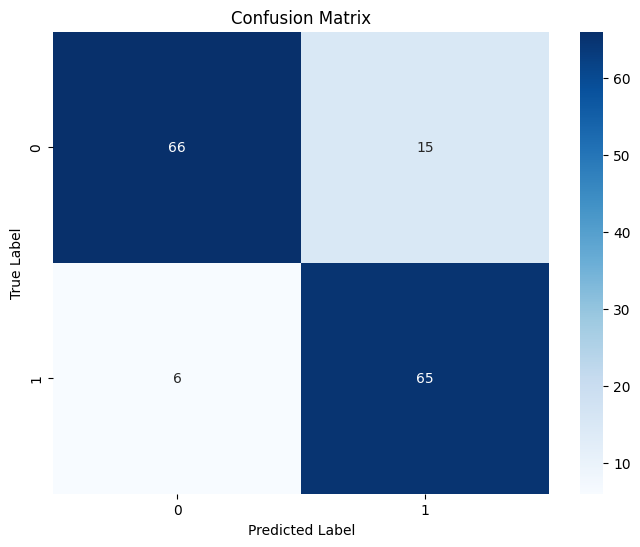

In [300]:
preprocessed_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(preprocessed_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##With next word negation

In [301]:
X = train_df['stopword_removed_nwn_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)

accuracy_scores = []
best_accuracy = 0
best_model = None
best_vocabulary = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(X_train)
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(X_test, vocabulary=vocabulary_train)

    nb_nwn_clf = MultinomialNaiveBayes()
    nb_nwn_clf.fit(tfidf_matrix_train, y_train, vocabulary_train)

    y_pred = nb_nwn_clf.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    # Update the best model if current fold's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = nb_nwn_clf

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = MultinomialNaiveBayes()
final_model.fit(tfidf_matrix_full, y, vocabulary_full)

# Save the final model and vocabulary
joblib.dump(final_model, 'nb_nwn_best_classifier.pkl')
joblib.dump(vocabulary_full, 'nb_nwn_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
nb_nwn_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", nb_nwn_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)

Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9738562091503268

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9084967320261438

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8954248366013072

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9281045751633987

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8947368421052632

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9276315789473685

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9342105263157895

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8881578947368421

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9539473684210527


###Confusion Matrix

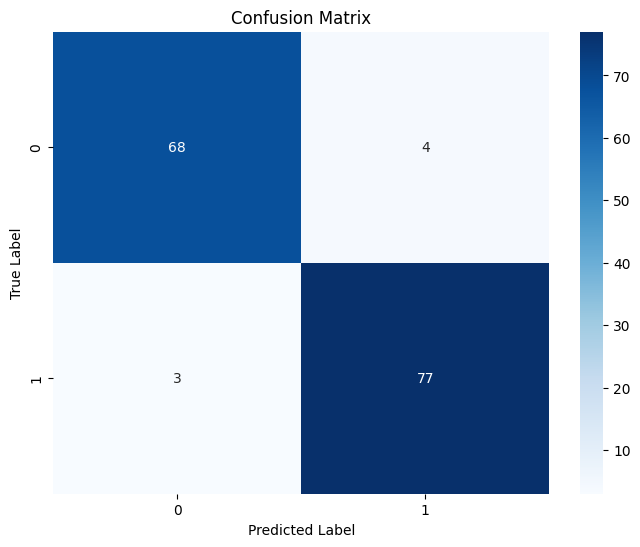

In [302]:
nwn_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(nwn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##With antonym

In [303]:
X = train_df['stopword_removed_antonym_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)

accuracy_scores = []
best_accuracy = 0
best_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(X_train)
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(X_test, vocabulary=vocabulary_train)

    nb_antonym_clf = MultinomialNaiveBayes()
    nb_antonym_clf.fit(tfidf_matrix_train, y_train, vocabulary_train)

    y_pred = nb_antonym_clf.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    # Update the best model if current fold's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = nb_antonym_clf

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = MultinomialNaiveBayes()
final_model.fit(tfidf_matrix_full, y, vocabulary_full)

# Save the current best model and vocabulary
joblib.dump(final_model, 'nb_antonym_best_classifier.pkl')
joblib.dump(vocabulary_full, 'nb_antonym_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
nb_antonym_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", nb_antonym_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)

Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8496732026143791

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9019607843137255

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8823529411764706

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8954248366013072

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8486842105263158

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8355263157894737

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8355263157894737

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8618421052631579


###Confusion Matrix

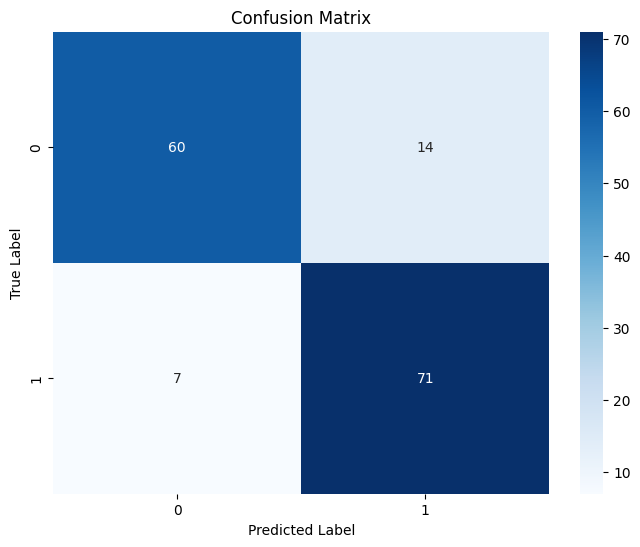

In [304]:
antonym_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(antonym_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##Combine the accuracy

In [305]:
NB_kfold_mean_accuracies = {
    'processed_accuracy': [nb_preprocessed_kfold_mean_accuracy],
    'nwn_accuracy': [nb_nwn_kfold_mean_accuracy],
    'antonym_accuracy': [nb_antonym_kfold_mean_accuracy]
}

nb_kfold_mean_acc = pd.DataFrame(NB_kfold_mean_accuracies, index=['Naive Bayes'])
nb_kfold_mean_acc

,processed_accuracy,nwn_accuracy,antonym_accuracy
Naive Bayes,0.867475,0.920588,0.871362


In [306]:
NB_kfold_mean_accuracies = {
    'processed_accuracy': [nb_preprocessed_kfold_mean_accuracy],
    'nwn_accuracy': [nb_nwn_kfold_mean_accuracy],
    'antonym_accuracy': [nb_antonym_kfold_mean_accuracy]
}

nb_kfold_mean_acc = pd.DataFrame(NB_kfold_mean_accuracies, index=['Naive Bayes'])
nb_kfold_mean_acc

,processed_accuracy,nwn_accuracy,antonym_accuracy
Naive Bayes,0.867475,0.920588,0.871362


#SVM

##Only preprocessed

In [307]:

X = train_df['stopword_removed_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)  # 5-fold cross-validation

accuracy_scores = []
best_accuracy = 0
best_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(X_train)
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(X_test, vocabulary=vocabulary_train)

    svm_preprocessed_classifier = SVC(kernel='rbf')
    svm_preprocessed_classifier.fit(tfidf_matrix_train, y_train)

    y_pred = svm_preprocessed_classifier.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    # Update the best model if current fold's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm_preprocessed_classifier

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = SVC(kernel='rbf')
final_model.fit(tfidf_matrix_full, y)

# Save the final model and vocabulary
joblib.dump(final_model, 'svm_preprocessed_best_classifier.pkl')
joblib.dump(vocabulary_full, 'svm_preprocessed_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
svm_preprocessed_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", svm_preprocessed_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)

Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.869281045751634

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8627450980392157

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8888888888888888

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8431372549019608

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9078947368421053

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8947368421052632

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8618421052631579

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8421052631578947

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.875

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Mean Accuracy

###Confusion Matrix

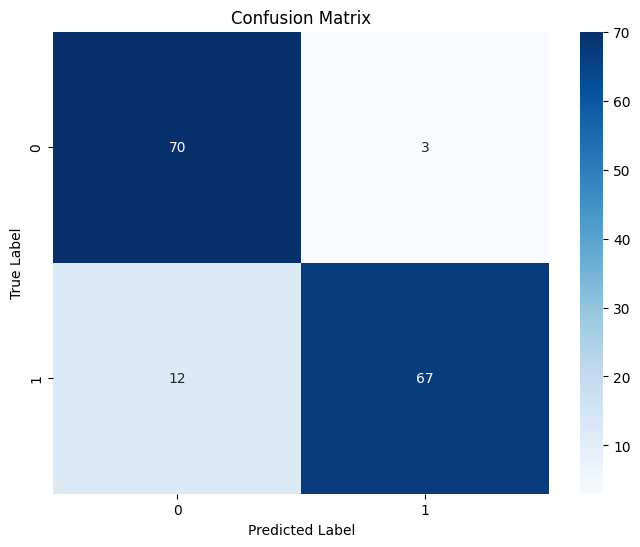

In [308]:
preprocessed_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(preprocessed_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_preprocessed_classifier.classes_,
            yticklabels=svm_preprocessed_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##With next word negation

In [309]:
X = train_df['stopword_removed_nwn_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)  # 5-fold cross-validation

accuracy_scores = []
best_accuracy = 0
best_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(X_train)
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(X_test, vocabulary=vocabulary_train)

    svm_nwn_classifier = SVC(kernel='rbf')
    svm_nwn_classifier.fit(tfidf_matrix_train, y_train)

    y_pred = svm_nwn_classifier.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    # Update the best model if current fold's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm_nwn_classifier

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = SVC(kernel='rbf')
final_model.fit(tfidf_matrix_full, y)

# Save the current best model and vocabulary
joblib.dump(final_model, 'svm_nwn_best_classifier.pkl')
joblib.dump(vocabulary_full, 'svm_nwn_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
svm_nwn_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", svm_nwn_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)

Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8888888888888888

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9084967320261438

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8954248366013072

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.934640522875817

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9078947368421053

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8552631578947368

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.875

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8552631578947368

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9276315789473685

Mean Accuracy

###Confusion Matrix

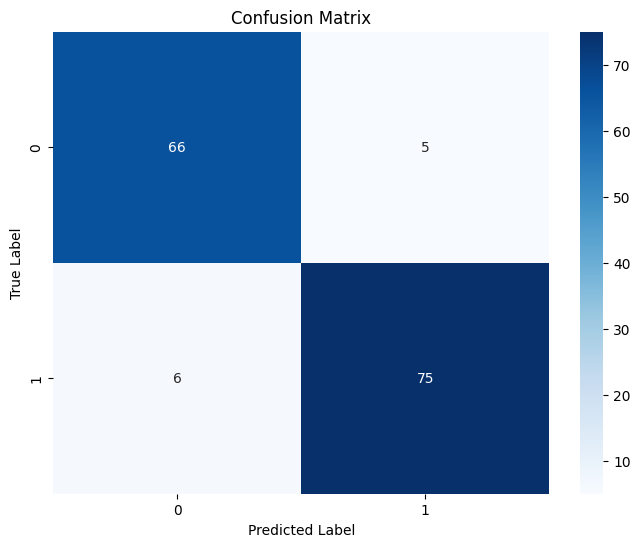

In [310]:
nwn_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(nwn_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_nwn_classifier.classes_,
            yticklabels=svm_nwn_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##After swapped with antonym

In [311]:
X = train_df['stopword_removed_antonym_processed']
y = train_df['sentiment_label']

kf = KFold(n_splits=10, shuffle=True)  # 5-fold cross-validation

accuracy_scores = []
best_accuracy = 0
best_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Fold {fold}:")
    print(f"  Training data size: {len(X_train)}")
    print(f"  Validation data size: {len(X_test)}")

    tfidf_matrix_train, vocabulary_train = vectorize_tfidf_from_processed_text(X_train)
    tfidf_matrix_test, _ = vectorize_tfidf_from_processed_text(X_test, vocabulary=vocabulary_train)

    svm_antonym_classifier = SVC(kernel='rbf')
    svm_antonym_classifier.fit(tfidf_matrix_train, y_train)

    y_pred = svm_antonym_classifier.predict(tfidf_matrix_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"  Fold accuracy: {accuracy}\n")

    # Update the best model if current fold's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm_antonym_classifier

# Train final model on the entire dataset
tfidf_matrix_full, vocabulary_full = vectorize_tfidf_from_processed_text(X)
final_model = SVC(kernel='rbf')
final_model.fit(tfidf_matrix_full, y)

# Save the current best model and vocabulary
joblib.dump(final_model, 'svm_antonym_best_classifier.pkl')
joblib.dump(vocabulary_full, 'svm_antonym_best_vectorizer.pkl')

# Calculate the mean accuracy over all folds
svm_antonym_kfold_mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", svm_antonym_kfold_mean_accuracy)
print("Best Fold Accuracy:", best_accuracy)

Fold 1:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8104575163398693

Fold 2:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8562091503267973

Fold 3:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.8823529411764706

Fold 4:
  Training data size: 1371
  Validation data size: 153
  Fold accuracy: 0.9019607843137255

Fold 5:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9342105263157895

Fold 6:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.881578947368421

Fold 7:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8618421052631579

Fold 8:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.8881578947368421

Fold 9:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.9013157894736842

Fold 10:
  Training data size: 1372
  Validation data size: 152
  Fold accuracy: 0.868421052631579

M

###Confusion Matrix

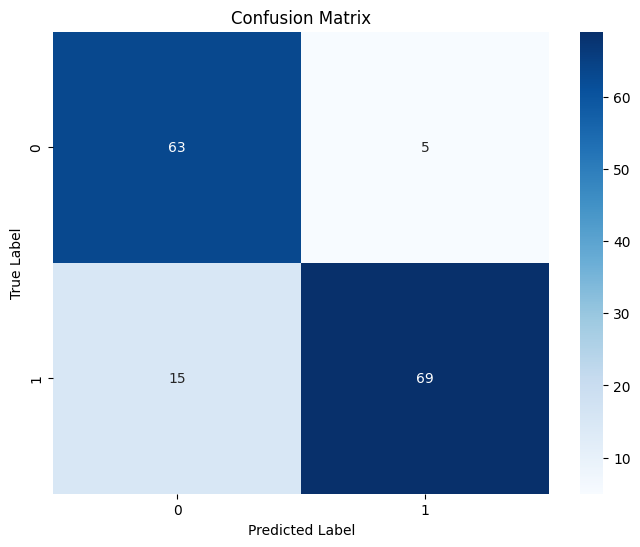

In [312]:
antonym_conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(antonym_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_antonym_classifier.classes_,
            yticklabels=svm_antonym_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##Combine the accuracy

In [313]:
svm_kfold_mean_data = {
    'processed_accuracy': [svm_preprocessed_kfold_mean_accuracy],
    'nwn_accuracy': [svm_nwn_kfold_mean_accuracy],
    'antonym_accuracy': [svm_antonym_kfold_mean_accuracy]
}

model_kfold_mean_acc = pd.concat([nb_kfold_mean_acc, pd.DataFrame(svm_kfold_mean_data, index=['SVM'])])
model_kfold_mean_acc

,processed_accuracy,nwn_accuracy,antonym_accuracy
Naive Bayes,0.867475,0.920588,0.871362
SVM,0.874695,0.894982,0.878651


In [314]:
svm_kfold_mean_data = {
    'processed_accuracy': [svm_preprocessed_kfold_mean_accuracy],
    'nwn_accuracy': [svm_nwn_kfold_mean_accuracy],
    'antonym_accuracy': [svm_antonym_kfold_mean_accuracy]
}

model_kfold_mean_acc = pd.concat([nb_kfold_mean_acc, pd.DataFrame(svm_kfold_mean_data, index=['SVM'])])
model_kfold_mean_acc

,processed_accuracy,nwn_accuracy,antonym_accuracy
Naive Bayes,0.867475,0.920588,0.871362
SVM,0.874695,0.894982,0.878651


In [315]:
train_df.to_csv('train_df_processed.csv')

#Pipeline

1. Preprocessed
2. Apply typo correction
3. Combine "nya" with the previous word
4. Combine "di" with the next word
5. Apply stemming
6. Apply next word negation
7. Apply antonym swapping
8. Apply stopword removal on preprocessed only
9. Apply stopword removal on next word negation
10. Apply stopword removal on antonym swapping

In [316]:
import joblib

def preprocess_pipeline(df, text_column):
    # Preprocess
    df['preprocessed'] = df[text_column].apply(preprocess_text)

    # Apply typo correction
    df['typo_corected'] = df['preprocessed'].apply(correct_typo)

    # Apply cleaning multiple letter typo
    df['typo_corrected'] = df['typo_corected'].apply(lambda x: correct_words_in_sentence(x, correct_words))

    # Combine "nya" with previous word
    df['combined_nya'] = df['typo_corrected'].apply(combine_nya_with_previous)

    # Combine "di" with previous word
    df['combined_di'] = df['combined_nya'].apply(combine_di_with_next)

    # Apply typo correction
    df['stemmed'] = df['combined_di'].apply(process_sentence)

    # Apply next word negation
    df['after_nwn_text'] = df['stemmed'].apply(next_word_negation)

    # Apply antonym swapping
    df['after_antonym_text'] = df['stemmed'].apply(swap_antonyms)

    # Remove stopwords on preprocessed only
    df["stopword_removed_processed"] = df["stemmed"].apply(
        lambda text: " ".join([word for word in text.split() if word not in stopwords])
    )

    # Remove stopwords on next word negation
    df["stopword_removed_nwn_processed"] = df["after_nwn_text"].apply(
        lambda text: " ".join([word for word in text.split() if word not in stopwords])
    )

    # Remove stopwords on antonym swapping
    df["stopword_removed_antonym_processed"] = df["after_antonym_text"].apply(
        lambda text: " ".join([word for word in text.split() if word not in stopwords])
    )

    return df

#Testing

In [317]:
test = pd.read_csv('/content/drive/MyDrive/Tugas Akhire/Dataset/test_labelled.csv')
processed_df = preprocess_pipeline(test_df, test_df.columns[0])
processed_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonym_text,stopword_removed_processed,stopword_removed_nwn_processed,stopword_removed_antonym_processed
923,"mantaaaap, barang sudah diterima",5,1,mantaaaap barang sudah diterima,mantaaaap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah terima,mantap barang sudah terima,mantap barang sudah terima,mantap barang terima,mantap barang terima,mantap barang terima
697,"Udah sampe,udh dicoba, lancar jaya gan\r\n\r\n...",5,1,udah sampe udh dicoba lancar jaya gan thx b...,sudah sampai sudah dicoba lancar jaya gan teri...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...
558,"Barang bagus,respon penjual cepat. Good seller",5,1,barang bagus respon penjual cepat good seller,barang bagus respon penjual cepat good seller,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter
551,Cukup baik. Sesuai harga,4,1,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga
1686,trimakasih brg sdh diterima dgn baik,5,1,trimakasih brg sdh diterima dgn baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang terima baik,trimakasih barang terima baik,trimakasih barang terima baik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,Batere nya cpt habis..????,2,0,batere nya cpt habis,batere nya cepat habis,batere nya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis
741,"Ternyata bahannya gk bs melar,,jd wlwpun bebas...",2,0,ternyata bahannya gk bs melar jd wlwpun beba...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...
1670,Agak beda dengan gambar produk yg dipajang (me...,1,0,agak beda dengan gambar produk yg dipajang mer...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,beda gambar produk pajang merk am bungkuk gamb...,beda gam

In [318]:
processed_df = preprocess_pipeline(test_df, test_df.columns[0])
processed_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonym_text,stopword_removed_processed,stopword_removed_nwn_processed,stopword_removed_antonym_processed
923,"mantaaaap, barang sudah diterima",5,1,mantaaaap barang sudah diterima,mantaaaap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah terima,mantap barang sudah terima,mantap barang sudah terima,mantap barang terima,mantap barang terima,mantap barang terima
697,"Udah sampe,udh dicoba, lancar jaya gan\r\n\r\n...",5,1,udah sampe udh dicoba lancar jaya gan thx b...,sudah sampai sudah dicoba lancar jaya gan teri...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...
558,"Barang bagus,respon penjual cepat. Good seller",5,1,barang bagus respon penjual cepat good seller,barang bagus respon penjual cepat good seller,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter
551,Cukup baik. Sesuai harga,4,1,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga
1686,trimakasih brg sdh diterima dgn baik,5,1,trimakasih brg sdh diterima dgn baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang terima baik,trimakasih barang terima baik,trimakasih barang terima baik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,Batere nya cpt habis..????,2,0,batere nya cpt habis,batere nya cepat habis,batere nya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis
741,"Ternyata bahannya gk bs melar,,jd wlwpun bebas...",2,0,ternyata bahannya gk bs melar jd wlwpun beba...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...
1670,Agak beda dengan gambar produk yg dipajang (me...,1,0,agak beda dengan gambar produk yg dipajang mer...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,beda gambar produk pajang merk am bungkuk gamb...,beda gam

In [319]:
y_test = processed_df['sentiment_label']
y_test

923     1
697     1
558     1
551     1
1686    1
       ..
1476    0
741     0
1670    0
1070    0
1382    0
Name: sentiment_label, Length: 170, dtype: int64

In [323]:
model_vectorizer_data = {
    'nb_preprocessed': ('nb_preprocessed_best_classifier.pkl', 'nb_preprocessed_best_vectorizer.pkl', 'stopword_removed_processed'),
    'nb_nwn': ('nb_nwn_best_classifier.pkl', 'nb_nwn_best_vectorizer.pkl', 'stopword_removed_nwn_processed'),
    'nb_antonym': ('nb_antonym_best_classifier.pkl', 'nb_antonym_best_vectorizer.pkl', 'stopword_removed_antonym_processed'),
    'svm_preprocessed': ('svm_preprocessed_best_classifier.pkl', 'svm_preprocessed_best_vectorizer.pkl', 'stopword_removed_processed'),
    'svm_nwn': ('svm_nwn_best_classifier.pkl', 'svm_nwn_best_vectorizer.pkl', 'stopword_removed_nwn_processed'),
    'svm_antonym': ('svm_antonym_best_classifier.pkl', 'svm_antonym_best_vectorizer.pkl', 'stopword_removed_antonym_processed')
}

accuracies = {}
for model_name, (model_file, vectorizer_file, text_column) in model_vectorizer_data.items():
    model = joblib.load(model_file)
    vectorizer = joblib.load(vectorizer_file)

    X_test_vec, _ = vectorize_tfidf_from_processed_text(processed_df[text_column], vocabulary=vectorizer)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies[model_name] = accuracy

best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])


print(f"The best model is {best_model} with an accuracy of {best_accuracy:.4f}")
accuracy_df

The best model is svm_preprocessed with an accuracy of 0.9294


,Model,Accuracy
0,nb_preprocessed,0.888235
1,nb_nwn,0.905882
2,nb_antonym,0.888235
3,svm_preprocessed,0.929412
4,svm_nwn,0.923529
5,svm_antonym,0.929412


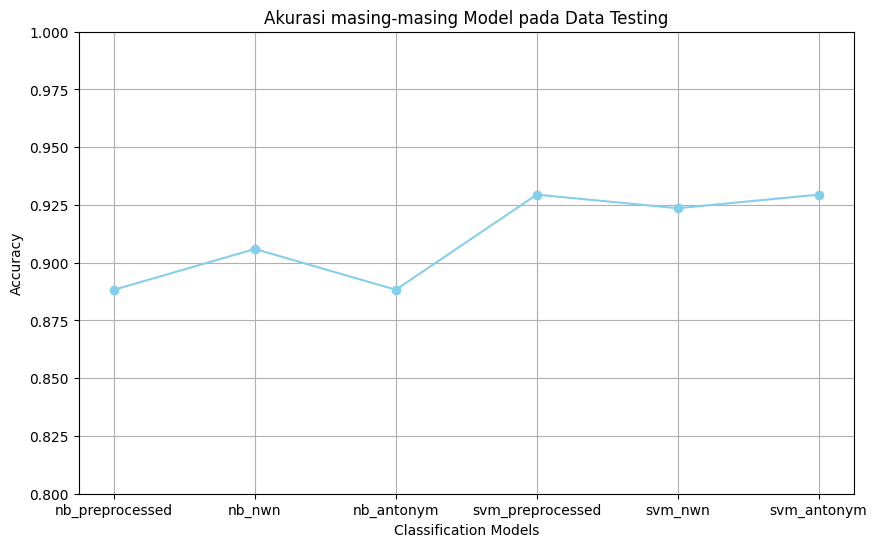

In [321]:
model_names = accuracy_df['Model']
accuracy_scores = accuracy_df['Accuracy']

plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracy_scores, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.title('Akurasi masing-masing Model pada Data Testing')
plt.ylim(0.8, 1)
plt.grid(True)
plt.show()

In [322]:
processed_df

,text,rating,sentiment_label,preprocessed,typo_corected,typo_corrected,combined_nya,combined_di,stemmed,after_nwn_text,after_antonym_text,stopword_removed_processed,stopword_removed_nwn_processed,stopword_removed_antonym_processed
923,"mantaaaap, barang sudah diterima",5,1,mantaaaap barang sudah diterima,mantaaaap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah diterima,mantap barang sudah terima,mantap barang sudah terima,mantap barang sudah terima,mantap barang terima,mantap barang terima,mantap barang terima
697,"Udah sampe,udh dicoba, lancar jaya gan\r\n\r\n...",5,1,udah sampe udh dicoba lancar jaya gan thx b...,sudah sampai sudah dicoba lancar jaya gan teri...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah dicoba lancar jaya an terim...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,sudah sampai sudah coba lancar jaya an terima ...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...,coba lancar jaya an terima kasih hari minggu k...
558,"Barang bagus,respon penjual cepat. Good seller",5,1,barang bagus respon penjual cepat good seller,barang bagus respon penjual cepat good seller,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter,barang bagus respons penjual cepat goods selter
551,Cukup baik. Sesuai harga,4,1,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga,cukup baik sesuai harga
1686,trimakasih brg sdh diterima dgn baik,5,1,trimakasih brg sdh diterima dgn baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah diterima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang sudah terima dengan baik,trimakasih barang terima baik,trimakasih barang terima baik,trimakasih barang terima baik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,Batere nya cpt habis..????,2,0,batere nya cpt habis,batere nya cepat habis,batere nya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis,baterenya cepat habis
741,"Ternyata bahannya gk bs melar,,jd wlwpun bebas...",2,0,ternyata bahannya gk bs melar jd wlwpun beba...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,ternyata bahannya tidak bisa melar jadi wlwpun...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan tidak bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...,nyata bahan tidak_bisa melar jadi wlwpun bebas...,nyata bahan melar jadi wlwpun bebas sice tetap...
1670,Agak beda dengan gambar produk yg dipajang (me...,1,0,agak beda dengan gambar produk yg dipajang mer...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang dipajang m...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,agak beda dengan gambar produk yang pajang mer...,beda gambar produk pajang merk am bungkuk gamb...,beda gam